HTML(value="<b><font color='black'>Segment any image!</b>")

Text(value='Must be valid image file/path (image.jpg)', description='Input image: ')

Label(value='(K-Means requires changing the value of K depending on num of colors in an image) ')

Final threshold value:  105


<IPython.core.display.Javascript object>


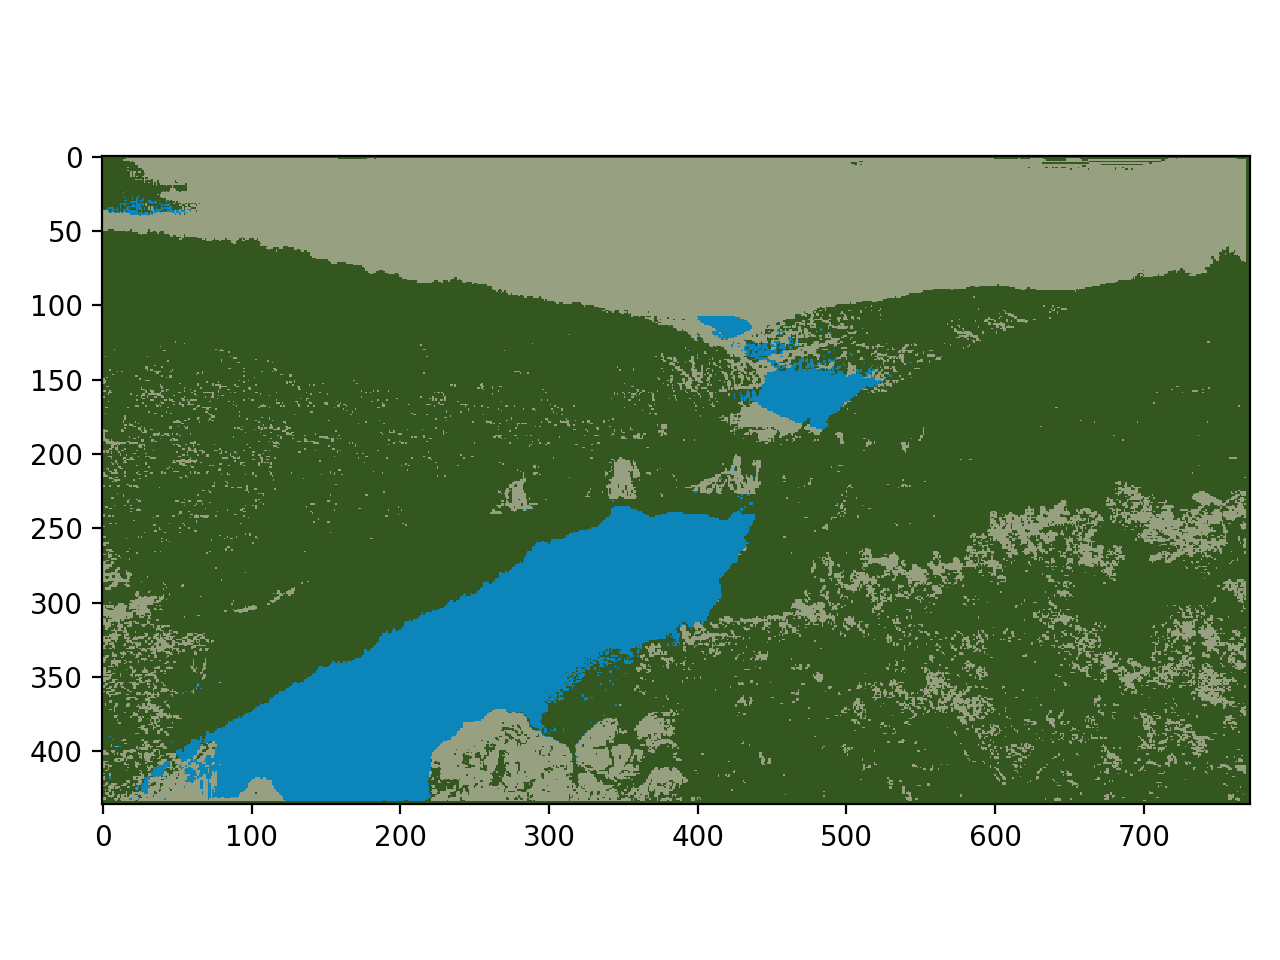

OSError: cannot open resource

Final threshold value:  105
Final threshold value:  105


In [2]:
# Kevin Kemmerer, CS433 Digital Image Processing, Otsu's method project

# Import Libraries for GUI, Images
import os
import cv2
import numpy as np
%matplotlib notebook
import pandas as pd
from ipywidgets import *
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
from skimage import io, color, data, filters, morphology
from skimage.filters import *
from PIL import Image, ImageDraw, ImageFont

# ignore warning messages
import warnings
warnings.filterwarnings('ignore')

# Labels
#w = widgets.Label(value="Segment any image!")
w = widgets.HTML(value = f"<b><font color='black'>{'Segment any image!'}</b>") # HTML wrapper to format label
display(w)
text = widgets.Text("Must be valid image file/path (image.jpg)", description="Input image: ", width=200)
display(text)
w = widgets.Label(value="(K-Means requires changing the value of K depending on num of colors in an image) ")
display(w)

button1 = widgets.Button(description="Otsu's method", width=100)
button1.style.button_color = 'lightgreen'
button2 = widgets.Button(description="K-Means", width=100)
button2.style.button_color = 'lightblue'
button3 = widgets.Button(description="Original Image", width=100)
# display(button1, button2, button3)
button_box = VBox([button1, button2, button3])
display(button_box)

# Otsu's Segmentation method
def otsu(img):
    pixels = img.shape[0] * img.shape[1]
    mean_weight = 1.0/pixels
    #print(mean_weight)
    histo, binar = np.histogram(img, np.arange(0,257))
    final_thresh = -1
    final_value = -1
    intensity_arr = np.arange(256)
    for t in binar[1:-1]: # for pixels 1-254 uint8
        # Pixel count of foreground/background from histo
        pcb = np.sum(histo[:t])
        pcf = np.sum(histo[t:])
        # printpcb, pcf
        # Calculating weight of foreground/background
        Wb = pcb * mean_weight
        Wf = pcf * mean_weight
        
        # Multiply intensity level to respective pixel counts (foreground, background)
        mub = np.sum(intensity_arr[:t]*histo[:t]) / float(pcb)
        muf = np.sum(intensity_arr[t:]*histo[t:]) / float(pcf)
        # print mub, muf
        # Threshold value calculation
        value = Wb * Wf * (mub - muf) ** 2
        
        # Final calculation to segment image
        if value > final_value:
            final_thresh = t
            final_value = value
    final_img = img.copy()
    print("Final threshold value: ",final_thresh)
    final_img[img > final_thresh] = 255 # If original image pixel is greater than final threshold then intensity = 255
    final_img[img < final_thresh] = 0 # If original image pixel is less tahn final threshold then intensity = 0
    return final_img

# number of clusters (K)
# Help from https://www.thepythoncode.com/article/kmeans-for-image-segmentation-opencv-python
def kmeans(img, k):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert from BGR to RGB Color
    # reshape the image to a 2D array of pixels
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)
    # Set criteria (How many itterations)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    
    # Calculate K-means
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    
     # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()
    
    segmented_image = centers[labels.flatten()]
    
    # Convert back to original image
    segmented_image = segmented_image.reshape(image.shape)
    
    return segmented_image

# Watermark an image (takes filename input, text for watermark)
def add_watermark(fileName, text):
    # Create an Image Object from an Image
    im = Image.open(fileName)
    width, height = im.size

    draw = ImageDraw.Draw(im)
    
    font = ImageFont.truetype('arial.ttf', 24)
    textwidth, textheight = draw.textsize(text, font)

    # calculate the x,y coordinates of the text
    margin = 10
    x = width - textwidth - margin
    y = height - textheight - margin

    # draw watermark in the bottom right corner
    draw.text((x, y), text, font=font)
    # im.show()

    # Save watermarked image
    # Modified such that if image is a .png it will save as png and vice versa
    if fileName.endswith((".png")):
        im.save(os.path.splitext(fileName)[0]+"_watermarked"+".png")
        watermarked_picture = Image.open(os.path.splitext(fileName)[0]+"_watermarked"+".png")
    else:
        im.save(os.path.splitext(fileName)[0]+"_watermarked"+".jpg")
        watermarked_picture = Image.open(os.path.splitext(fileName)[0]+"_watermarked"+".jpg")

    return watermarked_picture

# Initial Image from line of text
def handle_input(sender):
    input_image = text.value
    #print(text.value)
    #print(input_image)
    paper_img = io.imread(input_image)
    io.imshow(paper_img)

# Otsu's Method Button
def on_otsu_clicked(b1):
    input_image = text.value
    paper_img = cv2.imread(input_image)
    paper_image = cv2.cvtColor(paper_img, cv2.COLOR_BGR2GRAY)
    
    binary = otsu(paper_image)
    io.imshow(binary)
    
# K-Means Button
def on_knn_clicked(b2):
    input_image = text.value
    paper_img = cv2.imread(input_image)
    
    # Input (img,k) into kmeans function
    # K usually depends on how many colors are in the image - would like to have user input for this 
    kimage = kmeans(paper_img, 3)
    io.imshow(kimage)
    
# Original Image Button
def on_original_clicked(b3):
    input_image = text.value
    watermarked_picture = add_watermark(input_image, "Original Image")
    #paper_img = io.imread(input_image)
    final_pic = np.asarray(watermarked_picture)
    io.imshow(final_pic)
    
text.on_submit(handle_input)
button1.on_click(on_otsu_clicked)
button2.on_click(on_knn_clicked)
button3.on_click(on_original_clicked)
plt.show()

